# Cart Pole 강화학습 연습

<img src="https://github.com/aidentify/lecture/blob/master/study2/2_RL/img/cartpole_env.png?raw=1" width="600">

## Rendering에 필요한 모듈 설치

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


## 필요한 모듈 import
* gym (가상환경을 제공)
* numpy (텐서 연산)
* matplotlib (결과 그래프 출력)

In [2]:

import gym
import numpy as np
import matplotlib.pyplot as plt 

## 가상환경 설정 

* gym.make를 이용하여 등록된 'CartPole-v0' 환경을 env로 정의

In [3]:
env = gym.make('CartPole-v0')

##  hyper parameter 정의
* learning rate init: 초기 학습률 (시간 경과에 따른 학습률을 조정하기 위해)
* discount: 감쇄계수
* num_episodes: 전체 반복 학습 횟수
* max_trial: 실패하기 전까지 반복횟수
* num_success: 1차 학습 완료까지 기준
* streak_num_success: 1차성공 (199번 반복시까지 실패가 없을 경우)이 연속된 횟수
* status_check: 진행상황 확인 (IF TRUE)

In [4]:
learning_rate_init = 1.0
dis = 0.95

num_episodes = 1000
max_trial = 200
num_success = 199
streak_num_success = 100

status_check = True

## Episode 종료

1. 폴의 기울어진 각도가 ±15°보다 크거나 작을 때
2. 카트의 위치가 ±2.4 를 벗어날 때
3. 에피소드의 시도 횟수가 200회 이상일 때


## 학습 완료 기준

* 진행 episode = 1000 episode
* episode length = 200 timestep
* 성공조건 = timestep 199 달성
* 종료조건 = 100회 연속으로 성공

## CartPole-v0에서 정의한 State Boundary 및 Action Set

<img src="https://github.com/aidentify/lecture/blob/master/study2/2_RL/img/cartpole_env_boundary.png?raw=1" width="600">

In [5]:
# CartPole-v0 환경이 정의한 상태 경계값
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
print("states boundary: ", env.observation_space.low, env.observation_space.high )
print("STATE_BOUNDS [Min, Max]", STATE_BOUNDS)

# 상태 경계값을 조정 
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-1, 1]

# Action set 정의
num_actions = env.action_space.n
print("number of actions: ", num_actions)


states boundary:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
STATE_BOUNDS [Min, Max] [(-4.8, 4.8), (-3.4028235e+38, 3.4028235e+38), (-0.41887903, 0.41887903), (-3.4028235e+38, 3.4028235e+38)]
number of actions:  2


## Q-Table 작성을 위한 State Discretization

- Q-Table의 State: (S1,S2,S3,S4) := (카트 위치, 카트 수평속도, 폴의 기울기 각도, 폴의 각속도)
- 가상환경 env에서 만들어주는 연속적인 상태를 Q-Table 불연속 테이를로 매핑


In [6]:
# Q-Table에서의 상태 테이블
Q_State = (1, 1, 6, 3)

# Q-Table 정의
Q_Table = np.zeros(Q_State + (num_actions,))

# 연속적인 가상환경 ENV 상태를 불연속인 Q_STATE롷 변환
def state_to_table(state):
    q_state = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            state_index = 0
            
        elif state[i] >= STATE_BOUNDS[i][1]:
            state_index = Q_State[i] - 1
            
        else:
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (Q_State[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (Q_State[i]-1)/bound_width
            state_index = int(round(scaling*state[i] - offset))
        q_state.append(state_index)
    return tuple(q_state)


## Cart Pole 가상환경 관찰
* env.reset(): 가상환경 초기화 
* env.rener(): 가상환경 표현

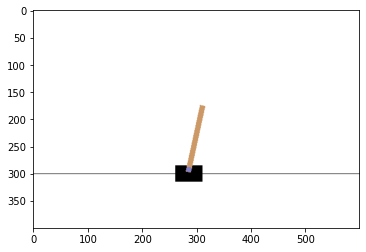

In [7]:
env.reset()

for i in range(100):
    random_action = env.action_space.sample()
    new_state, reward, done, info = env.step(random_action)
    screen=env.render(mode='rgb_array')
    plt.imshow(screen)
    if done:
        break
        

## Q-Learning 학습


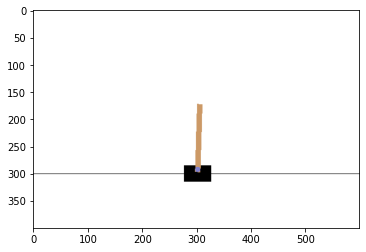


Episode = 7
t = 1
explore rate: 1.0 learning rate:  1.0
Action: 1
State: (0, 0, 3, 0)
Observation: [ 0.02418809  0.42171578  0.02405225 -0.56249446]
Reward: 1.000000
Best Q: 15.481289
Streaks: 0



In [ ]:

# 연속성공 카운터
num_streaks = 0 

# num_episodes만큼 반복학습
for i in range(num_episodes): 

    # 환경 초기화    
    obs = env.reset() 

    # state discretization
    state = state_to_table(obs)

    # e-greedy 계산 (expore_rate)
    e = 1. / ( i//20 + 1 )
    
    
    # learning rate decay factor 계산 
    df = 1. / ( i//20 + 1 )
    learning_rate = df*learning_rate_init
    
    # max_trial = 200
    for t in range(max_trial): 

        # 현재 상태 표현
        screen = env.render(mode='rgb_array')
        plt.imshow(screen) 
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        # e-greedy에 의한 행동 설정
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_Table[state])
            
        # 행동을 하면 환경이 새로운 상태를 보여줌 (보상값은 새로운 환경을 기준으로 사람이 설정)    
        obs, reward, done, _ = env.step(action) 

        # 연속적인 환경 변수에서 테이블로 표현된 불연속 Q-Table로 변경
        new_state = state_to_table(obs)

        # maxQ 값 선정
        maxQ = np.amax(Q_Table[new_state])
            
        # Q-Learning 공식을 이용한 Q-Table 업데이트    
        Q_Table[state + (action,)] += learning_rate*(reward + dis*maxQ - Q_Table[state + (action,)])
            
        state = new_state 

        # 진행상태 확인
        if (status_check):
            print("\nEpisode = %d" % i)
            print("t = %d" % t)
            print("explore rate:", e, "learning rate: ", learning_rate)
            print("Action: %d" % action)
            print("State: %s" % str(state))
            print("Observation: %s" % str(obs))
            print("Reward: %f" % reward)
            print("Best Q: %f" % maxQ)
            print("Streaks: %d" % num_streaks)
            print("")
            
        if done:
            # 성공조건 만족시 연속성공 카운팅 (199번 연속 안 쓰러뜨릴 경우)
            if (t >= num_success):
                num_streaks += 1
            
            # 성공조건 불만족시 카운터 초기화
            else:
                num_streaks = 0
                
            break

    # 학습완료조건 만족시 종료
    if num_streaks > streak_num_success:
        break
         
    ipythondisplay.clear_output(wait=True)
    env.close()